# Introduction

First, let's import libraries and the test and train data

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from datetime import datetime
from packaging import version
from keras import callbacks
import keras
from keras import layers
from keras_tuner.tuners import Hyperband
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier,RandomForestClassifier
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import roc_curve, auc
import shutil
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


In [2]:
#import data test and train to df 
df_test = pd.read_csv('test_data.csv')
df_train = pd.read_csv('train_data.csv')

In [3]:
#get shape of data
print(df_train.shape)
print(df_test.shape)

(29020, 19)
(7255, 19)


# EDA

In [4]:
#let's look for missing values
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29020 entries, 0 to 29019
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BookingID                29020 non-null  int64  
 1   LeadTime                 29020 non-null  int64  
 2   ArrivalYear              29020 non-null  int64  
 3   ArrivalMonth             29020 non-null  int64  
 4   ArrivalDate              29020 non-null  int64  
 5   NumWeekendNights         29020 non-null  int64  
 6   NumWeekNights            29020 non-null  int64  
 7   MealPlan                 29020 non-null  object 
 8   Parking                  29020 non-null  int64  
 9   RoomType                 29020 non-null  object 
 10  NumAdults                29020 non-null  int64  
 11  NumChildren              29020 non-null  int64  
 12  MarketSegment            29020 non-null  object 
 13  RepeatedGuest            29020 non-null  int64  
 14  NumPrevCancellations  

In [5]:
#take a look at train set
df_train.head()

,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,NumAdults,NumChildren,MarketSegment,RepeatedGuest,NumPrevCancellations,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests,BookingStatus
0,1,10,2018,3,31,0,1,Meal Plan 1,0,Room_Type 1,1,0,Corporate,0,0,0,95.00,0,Canceled
1,2,116,2018,2,28,2,1,Meal Plan 1,0,Room_Type 1,1,0,Online,0,0,0,61.00,0,Canceled
2,3,11,2018,7,25,1,2,Meal Plan 1,0,Room_Type 1,2,1,Online,0,0,0,129.75,1,Not_Canceled
3,4,3,2017,9,12,0,1,Meal Plan 1,0,Room_Type 1,2,0,Online,0,0,0,152.00,3,Not_Canceled
4,5,28,2018,3,7,1,3,Meal Plan 1,0,Room_Type 1,2,0,Offline,0,0,0,87.00,0,Not_Canceled


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7255 entries, 0 to 7254
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BookingID                7255 non-null   int64  
 1   LeadTime                 7255 non-null   int64  
 2   ArrivalYear              7255 non-null   int64  
 3   ArrivalMonth             7255 non-null   int64  
 4   ArrivalDate              7255 non-null   int64  
 5   NumWeekendNights         7255 non-null   int64  
 6   NumWeekNights            7255 non-null   int64  
 7   MealPlan                 7255 non-null   object 
 8   Parking                  7255 non-null   int64  
 9   RoomType                 7255 non-null   object 
 10  MarketSegment            7255 non-null   object 
 11  NumAdults                7255 non-null   int64  
 12  NumChildren              7255 non-null   int64  
 13  RepeatedGuest            7255 non-null   int64  
 14  NumPrevCancellations    

In [7]:
#generate summary statistics 
df_train.describe()

,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,Parking,NumAdults,NumChildren,RepeatedGuest,NumPrevCancellations,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests
count,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000
mean,14510.500000,85.276085,2017.819469,7.417333,15.589318,0.812646,2.207788,0.030772,1.846899,0.104445,0.025637,0.024673,0.159201,103.474264,0.620331
std,8377.496742,85.886439,0.384635,3.064481,8.743740,0.873318,1.421784,0.172702,0.518475,0.402892,0.158054,0.383250,1.821987,35.052557,0.786679
min,1.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7255.750000,17.000000,2018.000000,5.000000,8.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,80.750000,0.000000
50%,14510.500000,57.000000,2018.000000,8.000000,16.000000,1.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,99.865000,0.000000
75%,21765.250000,127.000000,2018.000000,10.000000,23.000000,2.000000,3.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,120.127500,1.000000
max,29020.000000,443.000000,2018.000000,12.000000,31.000000,7.000000,17.000000,1.000000,4.000000,10.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [8]:
#export the 'MarketSegment' column to a csv
df_train['MarketSegment'].to_csv('MarketSegment.csv', index=False)

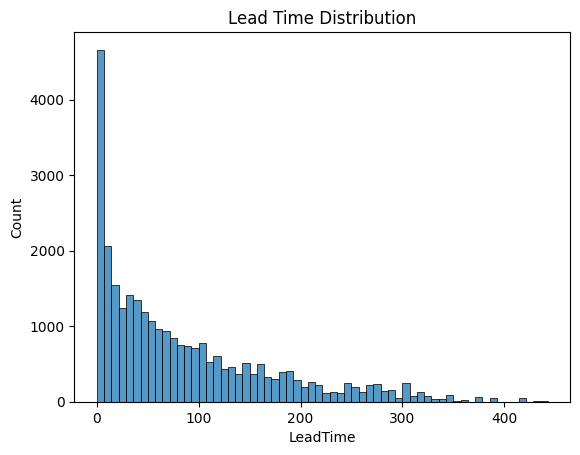

In [9]:
#histogram of lead time
sns.histplot(df_train['LeadTime'])
#add title
plt.title('Lead Time Distribution')
plt.show()

In [10]:
#get market segment value counts
markets = df_train['MarketSegment'].value_counts()



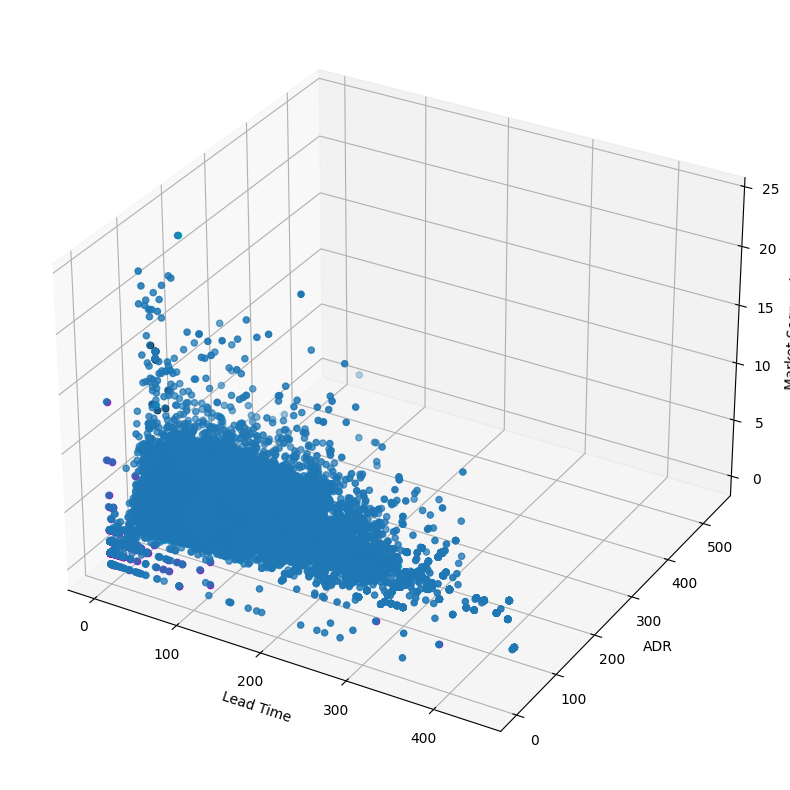

In [11]:
#make a 3d plot lead time price and market segment
num_nights = df_train['NumWeekendNights'] + df_train['NumWeekNights']
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_train['LeadTime'], df_train['AvgRoomPrice'], num_nights )
#highlight based on market segment
for i in range(len(df_train['MarketSegment'])):
    if df_train['MarketSegment'][i] == 'Online TA':
        ax.scatter(df_train['LeadTime'][i], df_train['AvgRoomPrice'][i], num_nights[i], c='r')
    elif df_train['MarketSegment'][i] == 'Offline TA/TO':
        ax.scatter(df_train['LeadTime'][i], df_train['AvgRoomPrice'][i], num_nights[i], c='b')
    elif df_train['MarketSegment'][i] == 'Groups':
        ax.scatter(df_train['LeadTime'][i], df_train['AvgRoomPrice'][i], num_nights[i], c='g')
    elif df_train['MarketSegment'][i] == 'Direct':
        ax.scatter(df_train['LeadTime'][i], df_train['AvgRoomPrice'][i], num_nights[i], c='y')
    elif df_train['MarketSegment'][i] == 'Corporate':
        ax.scatter(df_train['LeadTime'][i], df_train['AvgRoomPrice'][i], num_nights[i], c='c')
    elif df_train['MarketSegment'][i] == 'Complementary':
        ax.scatter(df_train['LeadTime'][i], df_train['AvgRoomPrice'][i], num_nights[i], c='m')
    elif df_train['MarketSegment'][i] == 'Aviation':
        ax.scatter(df_train['LeadTime'][i], df_train['AvgRoomPrice'][i], num_nights[i], c='k')
ax.set_xlabel('Lead Time')
ax.set_ylabel('ADR')
ax.set_zlabel('Market Segment')
plt.show()

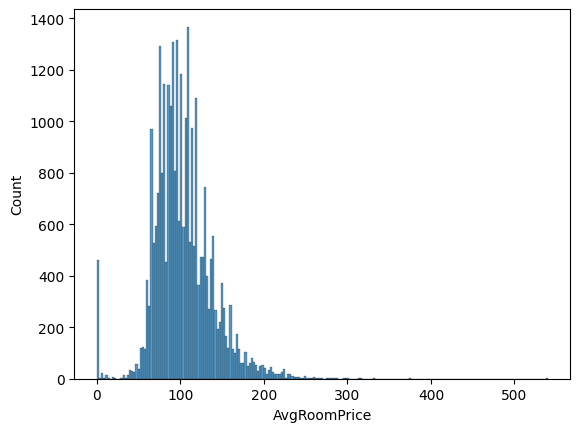

In [12]:
#let's make a histogram of AvgRoomPrice
sns.histplot(df_train['AvgRoomPrice'])
plt.show()

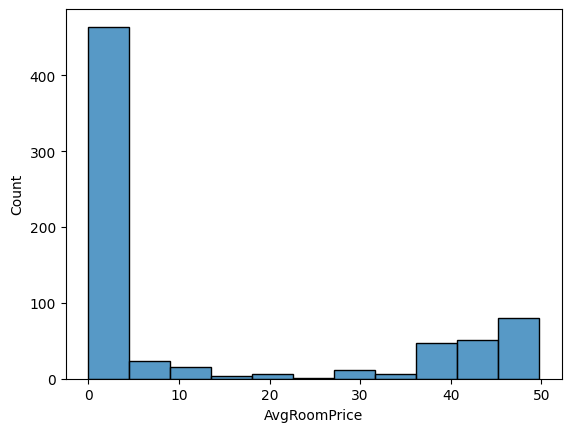

In [13]:
#It looks like there are some prices that are 0. Lets explore this

price_df=df_train[df_train.AvgRoomPrice < 50]
sns.histplot(price_df['AvgRoomPrice'])
plt.show()

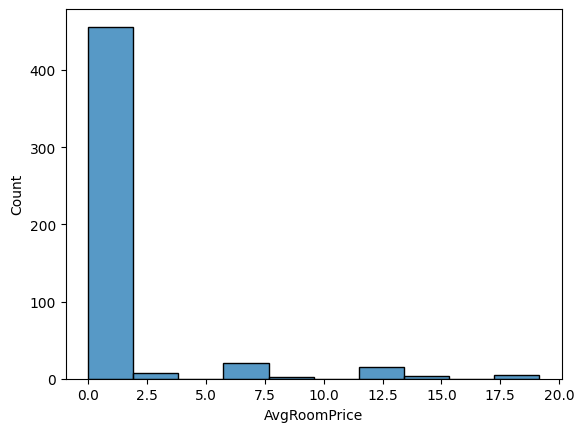

In [14]:
price_df=df_train[df_train.AvgRoomPrice < 20]
sns.histplot(price_df['AvgRoomPrice'])
plt.show()

In [15]:
price_df.head()

,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,NumAdults,NumChildren,MarketSegment,RepeatedGuest,NumPrevCancellations,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests,BookingStatus
7,8,1,2018,11,9,2,4,Meal Plan 1,0,Room_Type 1,1,0,Complementary,0,0,0,0.0,1,Not_Canceled
24,25,4,2018,10,14,0,2,Meal Plan 1,0,Room_Type 1,2,1,Complementary,1,0,7,0.0,1,Not_Canceled
95,96,0,2018,7,20,0,1,Meal Plan 2,0,Room_Type 1,2,0,Online,0,0,0,0.0,0,Not_Canceled
238,239,8,2018,4,23,0,1,Meal Plan 1,0,Room_Type 4,1,0,Complementary,0,0,0,0.0,2,Not_Canceled
294,295,5,2017,12,1,0,0,Meal Plan 1,0,Room_Type 1,1,0,Complementary,0,0,0,0.0,0,Not_Canceled


In [16]:
df_train.MarketSegment.unique()

array(['Corporate', 'Online', 'Offline', 'Complementary', 'Aviation'],
      dtype=object)

It makes sense for the complementary bookings to have a price of 0. However, booked online with a price of 0 does not make sense

In [17]:
price_df=price_df[price_df.MarketSegment != 'Complementary']
price_df.head()

,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,NumAdults,NumChildren,MarketSegment,RepeatedGuest,NumPrevCancellations,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests,BookingStatus
95,96,0,2018,7,20,0,1,Meal Plan 2,0,Room_Type 1,2,0,Online,0,0,0,0.0,0,Not_Canceled
1053,1054,60,2017,9,21,1,1,Meal Plan 1,0,Room_Type 1,1,0,Online,0,0,0,0.0,0,Not_Canceled
1246,1247,33,2018,2,20,0,0,Not Selected,0,Room_Type 1,2,0,Online,0,0,0,0.0,1,Not_Canceled
1377,1378,40,2018,1,14,0,3,Meal Plan 1,0,Room_Type 2,0,2,Online,0,0,0,6.0,1,Not_Canceled
1582,1583,147,2018,4,4,1,3,Meal Plan 1,0,Room_Type 2,0,2,Online,0,0,0,6.0,1,Not_Canceled


In [18]:
price_df.shape

(209, 19)

This data is most likely incorrect and should be removed

In [19]:
df_train=df_train.drop(df_train[(df_train.AvgRoomPrice == 0) & (df_train.MarketSegment != 'Complementary')].index)

Now we should also look at super high prices

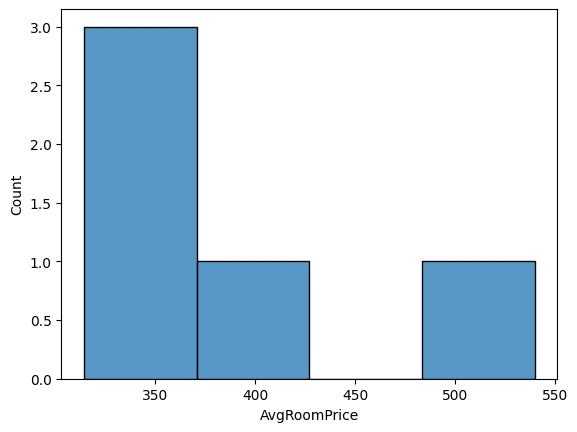

In [20]:
price_df=df_train[df_train.AvgRoomPrice > 300]
sns.histplot(price_df['AvgRoomPrice'])
plt.show()

In [21]:
price_df.head()

,BookingID,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,MealPlan,Parking,RoomType,NumAdults,NumChildren,MarketSegment,RepeatedGuest,NumPrevCancellations,NumPreviousNonCancelled,AvgRoomPrice,SpecialRequests,BookingStatus
4229,4230,57,2018,12,30,1,2,Meal Plan 2,0,Room_Type 4,2,0,Online,0,0,0,314.10,0,Not_Canceled
5221,5222,28,2018,6,2,0,3,Meal Plan 1,0,Room_Type 6,2,2,Online,0,0,0,332.57,1,Not_Canceled
18364,18365,6,2018,8,13,0,1,Meal Plan 2,1,Room_Type 6,2,2,Online,0,0,0,316.00,0,Canceled
23385,23386,21,2018,12,30,0,2,Meal Plan 1,0,Room_Type 4,3,0,Online,0,0,0,375.50,0,Not_Canceled
25237,25238,35,2018,3,25,0,1,Meal Plan 1,0,Room_Type 1,2,0,Offline,0,0,0,540.00,0,Canceled


These appear fine to keep in the dataset

Now lets look at some of the other columns

In [22]:
for col in df_train.drop(columns={'BookingID','ArrivalDate','LeadTime'}).columns.to_list():
    print(f"{col}: {df_train[col].unique()}")

ArrivalYear: [2018 2017]
ArrivalMonth: [ 3  2  7  9  6 11 12  4 10  1  8  5]
NumWeekendNights: [0 2 1 4 3 6 5 7]
NumWeekNights: [ 1  2  3  4  5  8  0  7  6 14  9 10 15 11 13 12 17 16]
MealPlan: ['Meal Plan 1' 'Meal Plan 2' 'Not Selected' 'Meal Plan 3']
Parking: [0 1]
RoomType: ['Room_Type 1' 'Room_Type 6' 'Room_Type 4' 'Room_Type 2' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']
NumAdults: [1 2 3 0 4]
NumChildren: [ 0  1  2  3  9 10]
MarketSegment: ['Corporate' 'Online' 'Offline' 'Complementary' 'Aviation']
RepeatedGuest: [0 1]
NumPrevCancellations: [ 0  2  3  1 11  5 13  4  6]
NumPreviousNonCancelled: [ 0  7  2 24 17  1  3  5 28 12 10  9 48  4  6 51 32 16 43 14 13  8 56 30
 20 40 34 38 42 23 27 26 22 25 11 15 55 44 18 50 45 29 31 41 35 21 39 37
 49 58 19 54 53 57 52 33]
AvgRoomPrice: [ 95.    61.   129.75 ... 246.25  64.72  78.9 ]
SpecialRequests: [0 1 3 2 4 5]
BookingStatus: ['Canceled' 'Not_Canceled']


In [23]:
for col in df_train.drop(columns={'BookingID','ArrivalDate','LeadTime'}).columns.to_list():
    print(f"{col}: {df_train[col].value_counts(normalize=True)}")

ArrivalYear: 2018    0.821505
2017    0.178495
Name: ArrivalYear, dtype: float64
ArrivalMonth: 10    0.145921
9     0.128283
8     0.105690
6     0.088121
7     0.081884
11    0.081606
12    0.081399
4     0.074815
5     0.072077
3     0.064696
2     0.047682
1     0.027826
Name: ArrivalMonth, dtype: float64
NumWeekendNights: 0    0.462679
1    0.276249
2    0.251265
3    0.004643
4    0.003396
5    0.001144
6    0.000589
7    0.000035
Name: NumWeekendNights, dtype: float64
NumWeekNights: 2     0.315268
1     0.260032
3     0.217548
4     0.083235
0     0.064939
5     0.044355
6     0.005198
7     0.003361
10    0.001733
8     0.001698
9     0.000970
11    0.000520
12    0.000277
15    0.000277
14    0.000243
13    0.000173
17    0.000104
16    0.000069
Name: NumWeekNights, dtype: float64
MealPlan: Meal Plan 1     0.767586
Not Selected    0.142179
Meal Plan 2     0.090062
Meal Plan 3     0.000173
Name: MealPlan, dtype: float64
Parking: 0    0.969055
1    0.030945
Name: Parking, dtype: 

There does not appear to be anything weird with the columns and their value distributions

Now lets look at class imbalance

In [24]:
df_train.BookingStatus.value_counts(normalize=True)

Not_Canceled    0.670247
Canceled        0.329753
Name: BookingStatus, dtype: float64

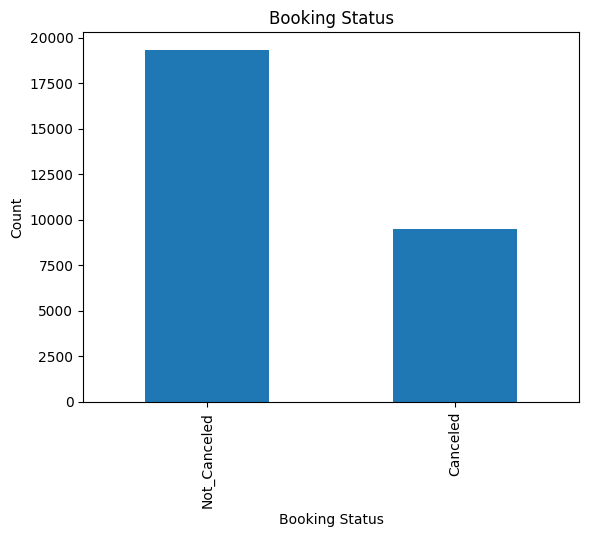

In [25]:
df_train['BookingStatus'].value_counts().plot(kind='bar')
#add title
plt.title('Booking Status')
#add x and y labels
plt.xlabel('Booking Status')
plt.ylabel('Count')
plt.show()

we have imbalanced classes. We will need to take this into account when training models

# Data Pre Processing
We will want to convert all of the columns into some form of numeric representation

In [26]:
#lets convert the booking status to a binary value
df_train['isCanceled'] = df_train['BookingStatus'].map({'Canceled': 1, 'Not_Canceled': 0})

In [27]:
#let's make dummy variables for the room type
room_type_dummies = pd.get_dummies(df_train['RoomType'], prefix='RoomType')
#now for meal plan
meal_plan_dummies = pd.get_dummies(df_train['MealPlan'], prefix='MealPlan')

market_segment_dummies = pd.get_dummies(df_train['MarketSegment'], prefix='MarketSegment')


In [28]:
#create a train df with the dummy variables, and the normalized values, and the binary values
df_train = pd.concat([df_train, room_type_dummies, meal_plan_dummies,market_segment_dummies], axis=1)

In [29]:
#let's look at the columns
df_train.columns

Index(['BookingID', 'LeadTime', 'ArrivalYear', 'ArrivalMonth', 'ArrivalDate',
       'NumWeekendNights', 'NumWeekNights', 'MealPlan', 'Parking', 'RoomType',
       'NumAdults', 'NumChildren', 'MarketSegment', 'RepeatedGuest',
       'NumPrevCancellations', 'NumPreviousNonCancelled', 'AvgRoomPrice',
       'SpecialRequests', 'BookingStatus', 'isCanceled',
       'RoomType_Room_Type 1', 'RoomType_Room_Type 2', 'RoomType_Room_Type 3',
       'RoomType_Room_Type 4', 'RoomType_Room_Type 5', 'RoomType_Room_Type 6',
       'RoomType_Room_Type 7', 'MealPlan_Meal Plan 1', 'MealPlan_Meal Plan 2',
       'MealPlan_Meal Plan 3', 'MealPlan_Not Selected',
       'MarketSegment_Aviation', 'MarketSegment_Complementary',
       'MarketSegment_Corporate', 'MarketSegment_Offline',
       'MarketSegment_Online'],
      dtype='object')

In [30]:
#let's remove bookingID, Room Type vals, hasMealPlan, MealPlanVals, and BookingStatus
df_train = df_train.drop(['BookingID','BookingStatus', 'RoomType', 'MealPlan','MarketSegment'], axis=1)


In [31]:
#now lets create a preprocess pipeline to do the same for the testing dataset

def preprocess(df):
    df['isCanceled'] = df['BookingStatus'].map({'Canceled': 1, 'Not_Canceled': 0})
    #let's make dummy variables for the room type
    room_type_dummies = pd.get_dummies(df['RoomType'], prefix='RoomType')
    #now for meal plan
    meal_plan_dummies = pd.get_dummies(df['MealPlan'], prefix='MealPlan')

    market_segment_dummies = pd.get_dummies(df['MarketSegment'], prefix='MarketSegment')

    df = pd.concat([df, room_type_dummies, meal_plan_dummies,market_segment_dummies], axis=1)

    df = df.drop(['BookingID','BookingStatus', 'RoomType', 'MealPlan','MarketSegment'], axis=1)

    return df


df_test=preprocess(df_test)



In [32]:
df_test.to_csv('df_test_final.csv')
df_train.to_csv('df_train_final.csv')

In [167]:
df_test.shape

(7255, 30)

# Feature Engineering

In [33]:
df_train.head()

,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,Parking,NumAdults,NumChildren,RepeatedGuest,...,RoomType_Room_Type 7,MealPlan_Meal Plan 1,MealPlan_Meal Plan 2,MealPlan_Meal Plan 3,MealPlan_Not Selected,MarketSegment_Aviation,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Offline,MarketSegment_Online
0,10,2018,3,31,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,116,2018,2,28,2,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,11,2018,7,25,1,2,0,2,1,0,...,0,1,0,0,0,0,0,0,0,1
3,3,2017,9,12,0,1,0,2,0,0,...,0,1,0,0,0,0,0,0,0,1
4,28,2018,3,7,1,3,0,2,0,0,...,0,1,0,0,0,0,0,0,1,0


Now, we scraped the weather for the region for each day of the stay as we felt those could be important features that influenced cancellation

In [34]:
df_train=pd.read_csv('df_train_final_weathered.csv').drop(columns={'Unnamed: 0','date'})
df_test=pd.read_csv('df_test_final_weathered.csv').drop(columns={'Unnamed: 0','date'})

In [35]:
df_train.columns

Index(['LeadTime', 'ArrivalYear', 'ArrivalMonth', 'ArrivalDate',
       'NumWeekendNights', 'NumWeekNights', 'Parking', 'NumAdults',
       'NumChildren', 'RepeatedGuest', 'NumPrevCancellations',
       'NumPreviousNonCancelled', 'AvgRoomPrice', 'SpecialRequests',
       'isCanceled', 'RoomType_Room_Type 1', 'RoomType_Room_Type 2',
       'RoomType_Room_Type 3', 'RoomType_Room_Type 4', 'RoomType_Room_Type 5',
       'RoomType_Room_Type 6', 'RoomType_Room_Type 7', 'MealPlan_Meal Plan 1',
       'MealPlan_Meal Plan 2', 'MealPlan_Meal Plan 3', 'MealPlan_Not Selected',
       'MarketSegment_Aviation', 'MarketSegment_Complementary',
       'MarketSegment_Corporate', 'MarketSegment_Offline',
       'MarketSegment_Online', 'maxtemp', 'mintemp', 'sunhour', 'totalsnow'],
      dtype='object')

In [36]:
df_test.shape

(7255, 34)

We can make new columns `number of nights stayed` and `total guests` 

In [37]:
def add_features(df):
    df['Total_Nights'] = df['NumWeekNights'] + df['NumWeekendNights']
    df['Total_Customers'] = df['NumChildren'] + df['NumAdults']
    
   
    return df


df_test=add_features(df_test)
df_train=add_features(df_train)
#We need to drop this cause the test dataset has no instances of it
df_train=df_train.drop(columns='MealPlan_Meal Plan 3')


In [38]:
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train['isCanceled'])

Now lets scale the data

In [39]:
#now lets create a preprocess pipeline to do the same for the testing dataset

def scale_data(df):
    X=df.drop(columns='isCanceled')

    y=df.isCanceled

    scale=StandardScaler()
    x_titles=X.columns.tolist()
    x_scaled=scale.fit_transform(X)
    X=pd.DataFrame(data=x_scaled,columns=x_titles)

    return X,y


X_test,y_test=scale_data(df_test)
X_train,y_train=scale_data(df_train)
X_val,y_val=scale_data(df_val)

Now lets do explore correlation to see which features can be removed

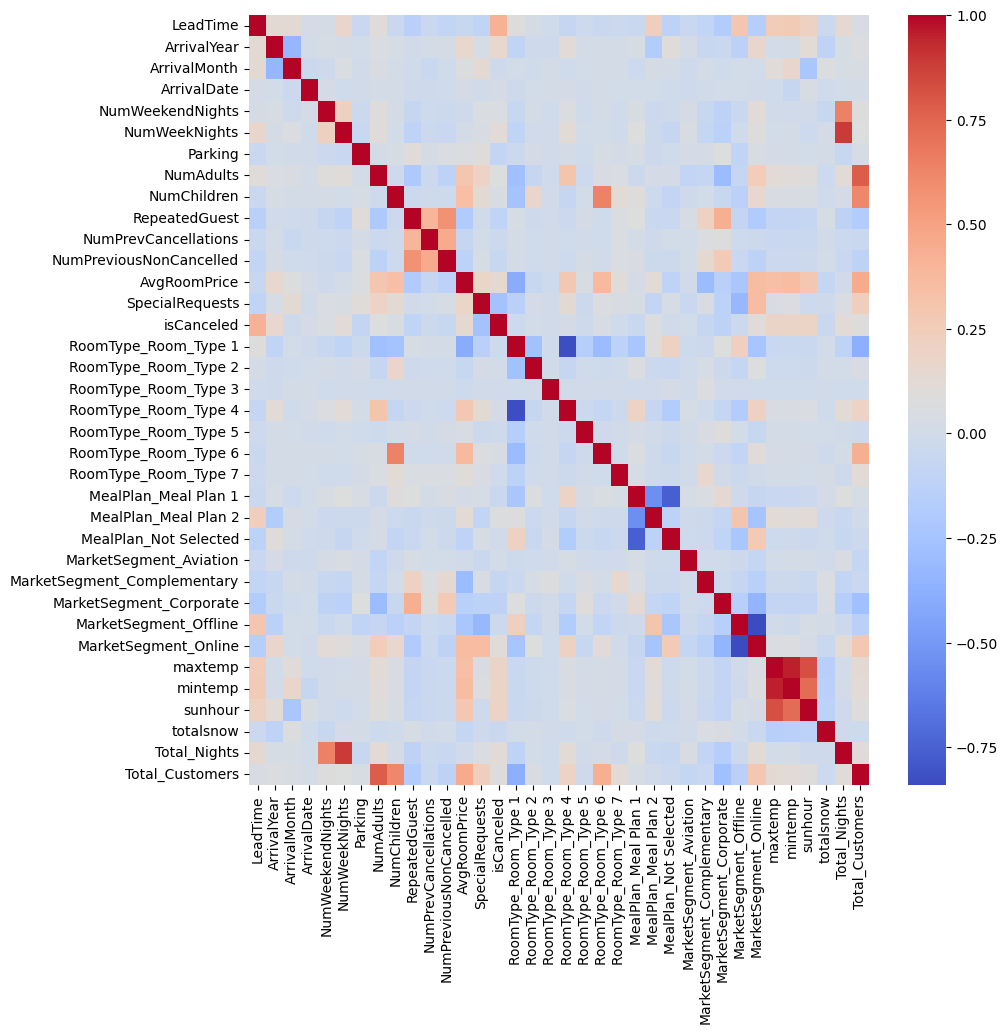

In [40]:
#let's make a correlation matrix
corr = df_train.corr()
#plot the correlation matrix
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()


Now lets use PCA.

PCA is an unsupervised ML algorithm that allows us to reduce the number of features that we have without loosing any of the information of the dataset.

PCA algorithms calculate a covariance matrix to show the relationship between each feature. We then use matrix factorization to find a pair of matrices that equal the covariance matrix, hence reducing the features without losing information. To do this, we use eigenvectors and eigenvalues to rotate a n-dimensional space to a 2-dimensional space.

To demonstrate my understanding, I will build a PCA algorithm before using scikit-learn model

In [41]:
eigenvalues ,eigenvectors =np.linalg.eig(corr)
# Find the proportion of information for each eigenvector, which is equal to the eigenvalues divided by the sum of all eigenvalues
info_prop = eigenvalues/eigenvalues.sum()

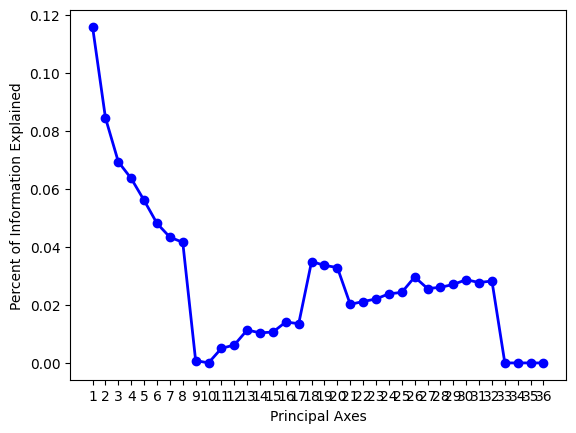

In [42]:
#Make a Scee plot to see how the percent of information explained changes with the number of features
plt.plot(np.arange(1,len(info_prop)+1),info_prop, 'bo-', linewidth=2)
plt.xlabel('Principal Axes')
plt.xticks(np.arange(1,len(info_prop)+1))
plt.ylabel('Percent of Information Explained')
plt.show()
plt.close()

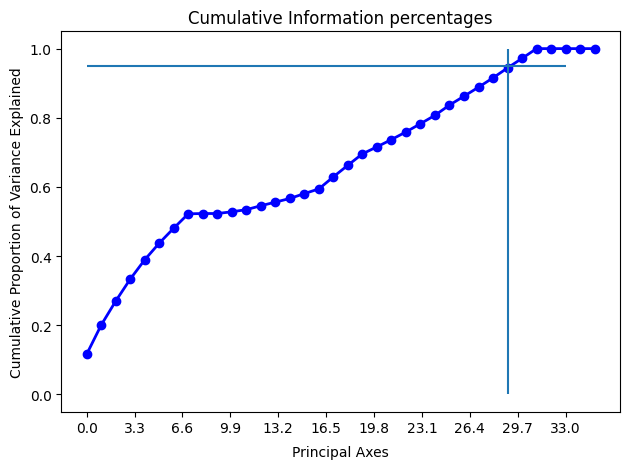

In [43]:
cum_info_prop = np.cumsum(info_prop)
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()
plt.plot(cum_info_prop, 'bo-', linewidth=2)
plt.hlines(y=.95, xmin=0, xmax=33)
plt.vlines(x=29, ymin=0, ymax=1)
plt.title('Cumulative Information percentages')
plt.xlabel('Principal Axes',labelpad=7)
plt.xticks(np.arange(1,len(info_prop)))
plt.ylabel('Cumulative Proportion of Variance Explained')
ax.set_xticks(np.linspace(0, 33, 11))
plt.show()
plt.close()


In [44]:
x_titles=df_train.columns
cum_info_prop=np.reshape(cum_info_prop,(1,36))
cum_info_prop= pd.DataFrame(columns=x_titles,data=cum_info_prop)
cum_info_prop

,LeadTime,ArrivalYear,ArrivalMonth,ArrivalDate,NumWeekendNights,NumWeekNights,Parking,NumAdults,NumChildren,RepeatedGuest,...,MarketSegment_Complementary,MarketSegment_Corporate,MarketSegment_Offline,MarketSegment_Online,maxtemp,mintemp,sunhour,totalsnow,Total_Nights,Total_Customers
0,0.115792,0.200234,0.269526,0.333085,0.389109,0.437193,0.480535,0.522092,0.522902,0.522916,...,0.86229,0.888332,0.915388,0.94406,0.971773,1.0,1.0,1.0,1.0,1.0


We see that 95% of the variance in the data is explained by 29 out of 36 features. This means we can drop 6 features to improve model performance

Now lets do recursive feature elimination to choose those 29 features

Recursive feature elimination is another wrapper method for feature selection. It starts by training a model with all available features. It then ranks each feature according to an importance metric and removes the least important feature. The algorithm then trains the model on the smaller feature set, ranks those features, and removes the least important one. The process stops when the desired number of features is reached.

I will use 29 features as the chosen amount since the PCA showed that 29 features explains 95% of the variance

In [45]:
feature_list = list(X_train.columns)

lr = LogisticRegression(max_iter=1000,class_weight='balanced')

# Recursive feature elimination
rfe = RFE(estimator=lr, n_features_to_select=29)
rfe.fit(X_train, y_train)

rfe_features = [f for (f, support) in zip(feature_list, rfe.support_) if support]

print(rfe_features)

# Print the accuracy of the model with features chosen by recursive feature elimination
print(rfe.score(X_train,y_train).round(4))

['LeadTime', 'ArrivalYear', 'ArrivalMonth', 'NumWeekendNights', 'Parking', 'NumChildren', 'RepeatedGuest', 'NumPrevCancellations', 'NumPreviousNonCancelled', 'AvgRoomPrice', 'SpecialRequests', 'RoomType_Room_Type 1', 'RoomType_Room_Type 2', 'RoomType_Room_Type 5', 'RoomType_Room_Type 6', 'RoomType_Room_Type 7', 'MealPlan_Meal Plan 1', 'MealPlan_Meal Plan 2', 'MealPlan_Not Selected', 'MarketSegment_Aviation', 'MarketSegment_Complementary', 'MarketSegment_Offline', 'MarketSegment_Online', 'maxtemp', 'mintemp', 'sunhour', 'totalsnow', 'Total_Nights', 'Total_Customers']
0.7762


Now lets keep those features

In [46]:
X_train = X_train[rfe_features]
X_val = X_val[rfe_features]
#switch X_test's column headers to that of X_train
X_test = X_test[['LeadTime', 'ArrivalYear', 'ArrivalMonth', 'NumWeekendNights', 'Parking', 'NumChildren', 'RepeatedGuest', 'NumPrevCancellations', 'NumPreviousNonCancelled', 'AvgRoomPrice', 'SpecialRequests', 'RoomType_Room_Type 1', 'RoomType_Room_Type 2', 'RoomType_Room_Type 5', 'RoomType_Room_Type 6', 'RoomType_Room_Type 7', 'MealPlan_Meal Plan 1', 'MealPlan_Meal Plan 2', 'MealPlan_Not Selected', 'MarketSegment_Aviation', 'MarketSegment_Complementary', 'MarketSegment_Offline', 'MarketSegment_Online', 'maxtemp', 'mintemp', 'sunhour', 'totalsnow', 'Total_Nights', 'Total_Customers']]


In [47]:
X_train.shape

(19507, 29)

# Model Selection

## Logistic Regression

Logistic regressions are similar to a linear regression except it is used to predict a binary output. It uses log-odds or a sigmoid function to compute probabilities of a data point falling within a class. Based on some threshold it then classifies the point as 0 or 1. 

In [48]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(class_weight='balanced')
lr.fit(X_train,y_train)
y_pred=lr.predict(X_val)

print(f'accruacy: {lr.score(X_val,y_val).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred))

accruacy: 0.7751
Confusion Matrix: 
[[2559  736]
 [ 361 1221]]
classification report: 
              precision    recall  f1-score   support

           0       0.88      0.78      0.82      3295
           1       0.62      0.77      0.69      1582

    accuracy                           0.78      4877
   macro avg       0.75      0.77      0.76      4877
weighted avg       0.79      0.78      0.78      4877



### Bagging

In [51]:
#lets bag the logistic regression model
lr=LogisticRegression(max_iter=1000,class_weight='balanced')
bag_lr=BaggingClassifier(estimator=lr,n_estimators=20,random_state=42)
bag_lr.fit(X_train,y_train)
y_pred=bag_lr.predict(X_val)

print(f'accruacy: {bag_lr.score(X_val,y_val).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred))



accruacy: 0.773
Confusion Matrix: 
[[2551  744]
 [ 363 1219]]
classification report: 
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      3295
           1       0.62      0.77      0.69      1582

    accuracy                           0.77      4877
   macro avg       0.75      0.77      0.75      4877
weighted avg       0.79      0.77      0.78      4877



### Boosting

In [116]:
#let's use ada boost to see if we can improve the model
ada_lr=AdaBoostClassifier(estimator=lr,n_estimators=20,random_state=42)
ada_lr.fit(X_train,y_train)
y_pred=ada_lr.predict(X_val)

print(f'accruacy: {ada_lr.score(X_val,y_val).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred))

accruacy: 0.7726
Confusion Matrix: 
[[2559  736]
 [ 373 1209]]
classification report: 
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      3295
           1       0.62      0.76      0.69      1582

    accuracy                           0.77      4877
   macro avg       0.75      0.77      0.75      4877
weighted avg       0.79      0.77      0.78      4877



### Tuning

In [58]:
#now for some parameter tuning
#use random search to find the best parameter

param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'bootstrap': [True, False],
                'bootstrap_features': [True, False]}




# Instantiate the grid search model
random_search = RandomizedSearchCV(estimator = bag_lr, param_distributions = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2, random_state=42)

# Fit the grid search to the data
random_search.fit(X_train, y_train)

print(random_search.best_params_)
print(random_search.best_score_)

Fitting 3 folds for each of 4000 candidates, totalling 12000 fits


KeyboardInterrupt: 

In [53]:
results = pd.DataFrame(random_search.cv_results_)

heatmap_data = results.pivot(index='param_C', columns='param_gamma', values='mean_test_score')

# Create heatmap
sns.heatmap(heatmap_data, annot=True, cmap='Blues')

# Add labels and title
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('GridSearchCV Results')

KeyError: 'param_C'

## K Nearest Neighbours

This model works by assuming data of the same class will be close to eachother. It uses the distance formula to determine how close an item is to other items of a known class. Then, using k, or the number of closest neighbours to assess, it classifies the point based on majority rules of what class of points are closest to it. Generally, a k of around 5 is acceptable

We use SMOTE to balance the class weights

In [118]:
# Fit SMOTE to the training set
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train the model on the resampled data
k_neigh = KNeighborsClassifier(n_neighbors=5)
k_neigh.fit(X_resampled, y_resampled)

# Transform the test set using the existing SMOTE object
y_pred=k_neigh.predict(X_val)

print(f'accruacy: {k_neigh.score(X_val,y_val).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred))



accruacy: 0.8177
Confusion Matrix: 
[[2691  604]
 [ 285 1297]]
classification report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      3295
           1       0.68      0.82      0.74      1582

    accuracy                           0.82      4877
   macro avg       0.79      0.82      0.80      4877
weighted avg       0.83      0.82      0.82      4877



### Bagging

In [119]:
bagged_kmeans = BaggingClassifier(estimator=k_neigh, n_estimators=60, random_state=42)
bagged_kmeans.fit(X_resampled, y_resampled)

# Predict the labels of the test set
y_pred = bagged_kmeans.predict(X_val)

# Evaluate the accuracy score
print(f'accruacy: {bagged_kmeans.score(X_val,y_val).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred))

accruacy: 0.8222
Confusion Matrix: 
[[2703  592]
 [ 275 1307]]
classification report: 
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      3295
           1       0.69      0.83      0.75      1582

    accuracy                           0.82      4877
   macro avg       0.80      0.82      0.81      4877
weighted avg       0.84      0.82      0.83      4877



### Tuning

In [120]:


# Create the parameter grid based for bagging k nearest neighbors
param_grid = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                'bootstrap': [True, False],
                'bootstrap_features': [True, False]}






# Instantiate the grid search model
random_search = RandomizedSearchCV(estimator = bagged_kmeans, param_distributions = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2, random_state=42)

# Fit the grid search to the data
random_search.fit(X_resampled, y_resampled)

print(random_search.best_params_)
print(random_search.best_score_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 50, 'max_samples': 1.0, 'max_features': 0.3, 'bootstrap_features': False, 'bootstrap': True}
0.8741179148645571


## Decision Tree

A decision tree is another classification model that looks at patterns in a dataset and breaks down data feature by feature to classify. 

The tree keeps splitting to lower the gini impurity (1 - sum of squared probabilties) to increase the information gain

In [121]:
dTree= DecisionTreeClassifier(max_depth=3,class_weight='balanced')
dTree.fit(X_train,y_train)
y_pred= dTree.predict(X_val)
print(f'accruacy: {dTree.score(X_val,y_val).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred,zero_division=0))

accruacy: 0.7781
Confusion Matrix: 
[[2657  638]
 [ 444 1138]]
classification report: 
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      3295
           1       0.64      0.72      0.68      1582

    accuracy                           0.78      4877
   macro avg       0.75      0.76      0.75      4877
weighted avg       0.79      0.78      0.78      4877



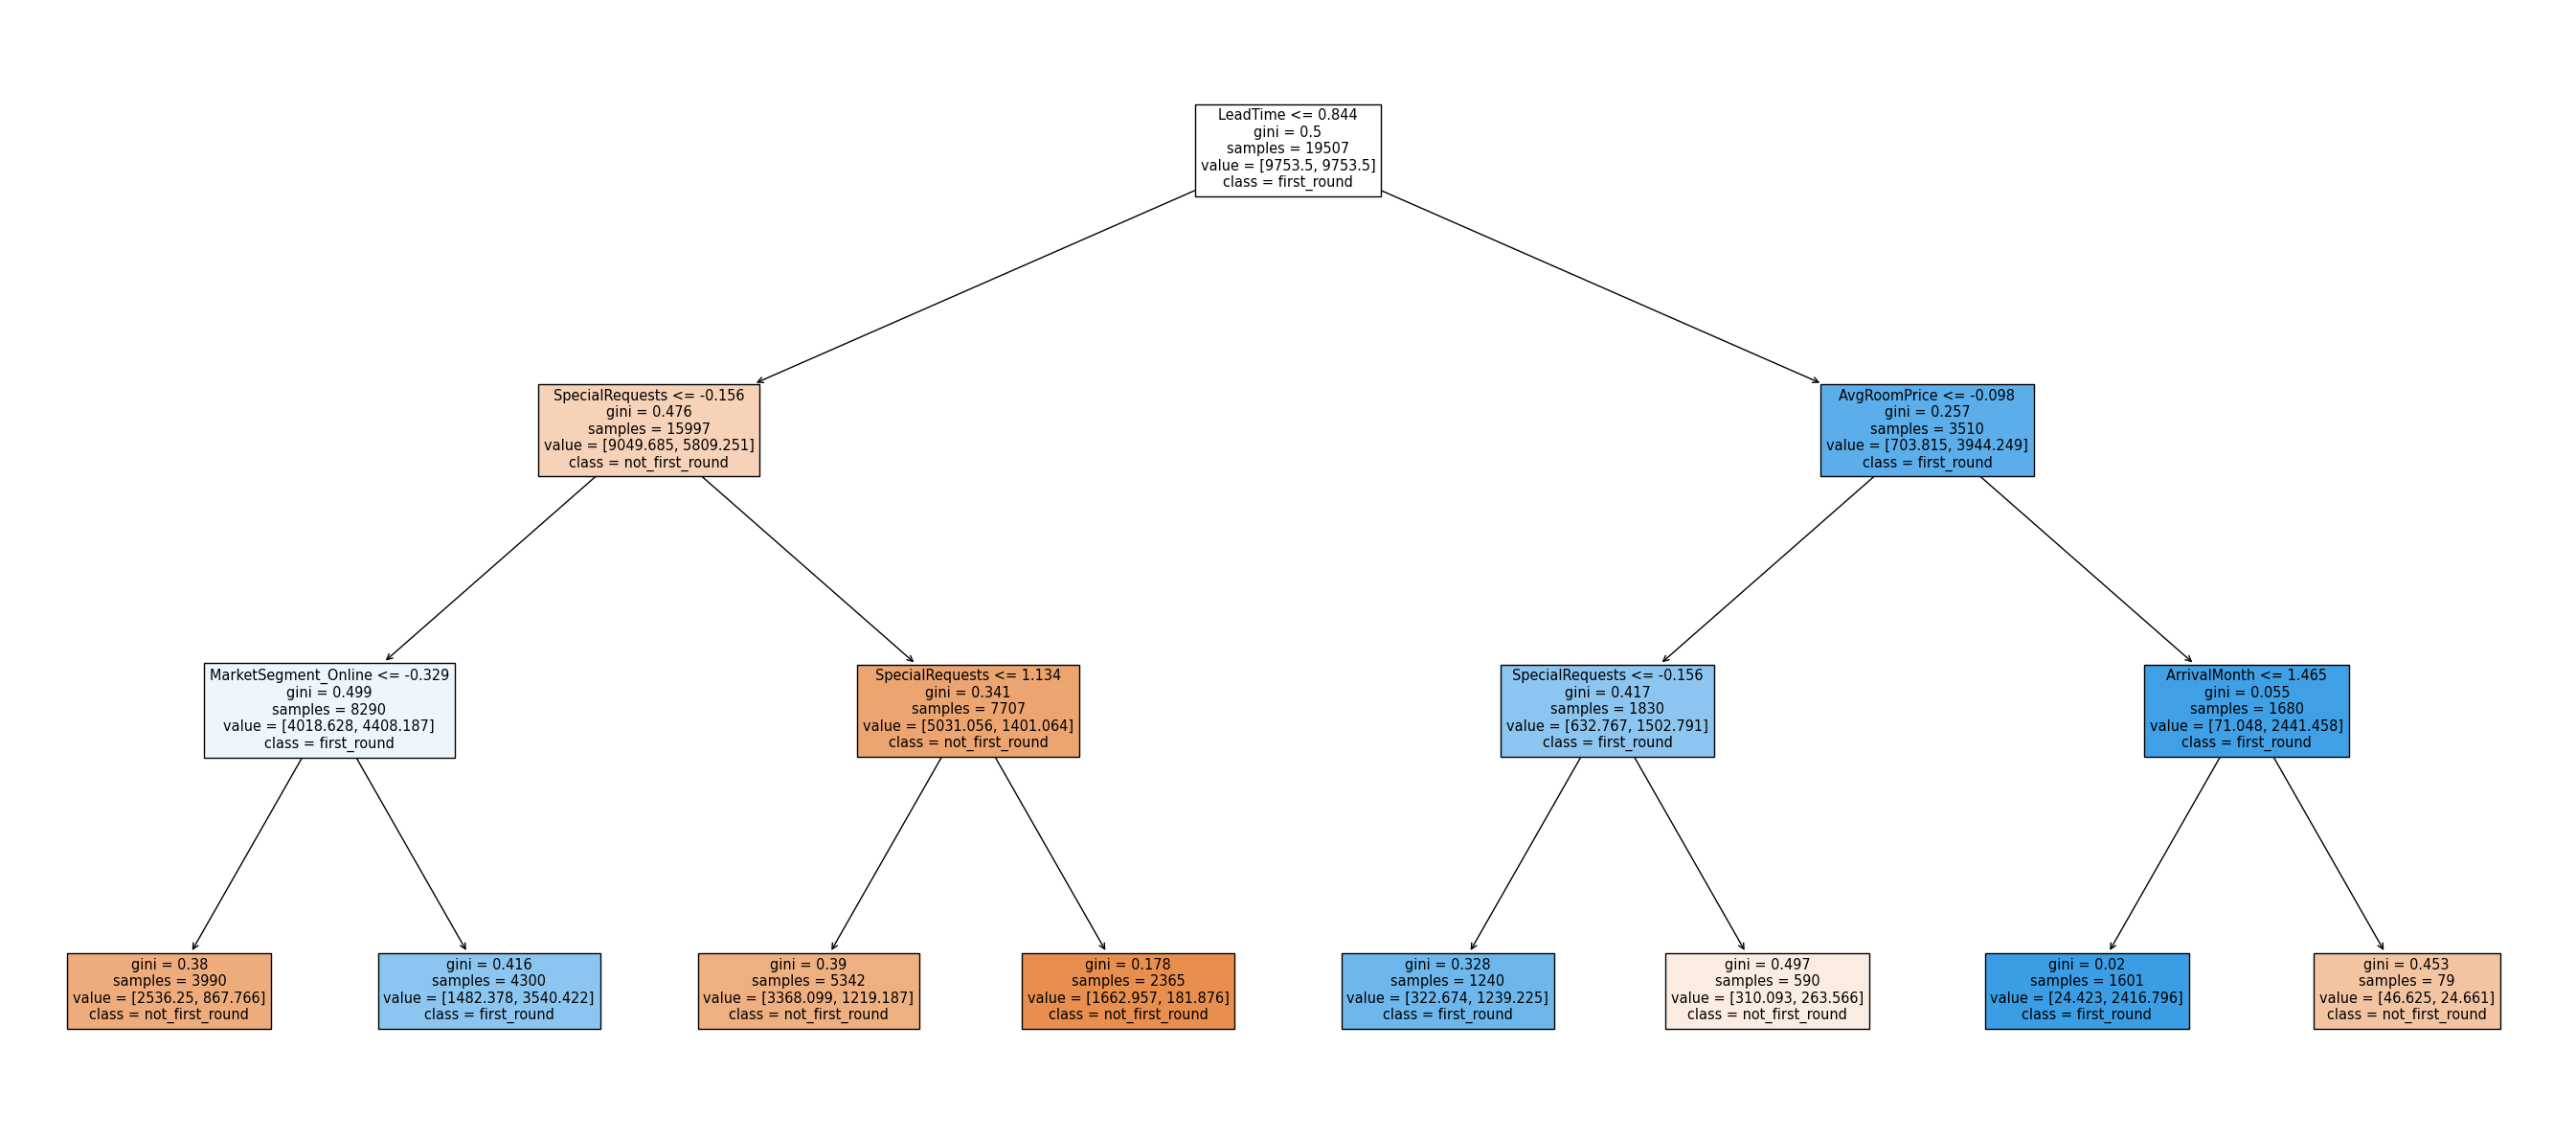

In [122]:
#Lets visualize the tree
plt.figure(figsize=(27,12))
tree.plot_tree(dTree,feature_names =X_train.columns,class_names=['not_first_round','first_round'],filled=True)
plt.tight_layout()
plt.show()

## Support Vector Machines (SVM)

SVM's work by defining a decision boundary and making a classification based off of which side of the boundary the point falls on.

This model has high computational speed as we only are worried about the points on the decision boundary margin. I will use a RBF kernal 

In [123]:
svc=SVC(kernel = "rbf",class_weight='balanced')

svc.fit(X_train,y_train)

y_pred= svc.predict(X_val)
print(f'accruacy: {svc.score(X_val,y_val).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred))

accruacy: 0.8134
Confusion Matrix: 
[[2668  627]
 [ 283 1299]]
classification report: 
              precision    recall  f1-score   support

           0       0.90      0.81      0.85      3295
           1       0.67      0.82      0.74      1582

    accuracy                           0.81      4877
   macro avg       0.79      0.82      0.80      4877
weighted avg       0.83      0.81      0.82      4877



### Bagging

In [124]:
#now let's try a bagging classifier
bagging=BaggingClassifier(estimator=svc,n_estimators=10,random_state=0)
bagging.fit(X_train,y_train)
y_pred= bagging.predict(X_val)
print(f'accruacy: {bagging.score(X_val,y_val).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred))

accruacy: 0.8169
Confusion Matrix: 
[[2699  596]
 [ 297 1285]]
classification report: 
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      3295
           1       0.68      0.81      0.74      1582

    accuracy                           0.82      4877
   macro avg       0.79      0.82      0.80      4877
weighted avg       0.83      0.82      0.82      4877



### Tuning

In [129]:
#lets try and tune the hyperparameters of the bagging classifier
#random grid search
# Create the parameter grid based on the results of random search
param_grid = {
    'base_estimator__kernel': ['rbf', 'poly'],
    'base_estimator__C': [0.1, 1, 10, 1000],
    'base_estimator__gamma': [1, 0.001, 0.0001],
    'n_estimators': [100, 200, 1000]
}


# Instantiate the grid search model
grid_search = RandomizedSearchCV(estimator = bagging, param_distributions = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters
print(grid_search.best_params_)
print(grid_search.best_score_)

print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


## MLP

In [ ]:
# Define model architecture
input_shape=len(X_train.columns)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(input_shape, )),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_resampled, y_resampled, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, early_stop])

Epoch 1/50
412/412 [==============================] - 4s 6ms/step - loss: 0.5720 - accuracy: 0.7043 - val_loss: 0.4556 - val_accuracy: 0.7781
Epoch 2/50
412/412 [==============================] - 2s 5ms/step - loss: 0.4848 - accuracy: 0.7716 - val_loss: 0.4436 - val_accuracy: 0.7798
Epoch 3/50
412/412 [==============================] - 2s 6ms/step - loss: 0.4650 - accuracy: 0.7817 - val_loss: 0.4302 - val_accuracy: 0.7853
Epoch 4/50
412/412 [==============================] - 2s 5ms/step - loss: 0.4533 - accuracy: 0.7880 - val_loss: 0.4244 - val_accuracy: 0.7939
Epoch 5/50
412/412 [==============================] - 2s 5ms/step - loss: 0.4416 - accuracy: 0.7936 - val_loss: 0.4209 - val_accuracy: 0.7939
Epoch 6/50
412/412 [==============================] - 2s 4ms/step - loss: 0.4360 - accuracy: 0.7955 - val_loss: 0.4078 - val_accuracy: 0.8034
Epoch 7/50
412/412 [==============================] - 2s 5ms/step - loss: 0.4298 - accuracy: 0.8001 - val_loss: 0.4085 - val_accuracy: 0.8040
Epoch 

In [ ]:
y_pred = model.predict(X_val)
y_pred = np.round(y_pred)

print(f'accruacy: {accuracy_score(y_val,y_pred).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred,zero_division=0))

153/153 [==============================] - 0s 2ms/step
accruacy: 0.8433
Confusion Matrix: 
[[2814  481]
 [ 283 1299]]
classification report: 
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      3295
           1       0.73      0.82      0.77      1582

    accuracy                           0.84      4877
   macro avg       0.82      0.84      0.83      4877
weighted avg       0.85      0.84      0.85      4877



### Tuning

In [ ]:
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
def create_model(hp):
    input_shape=len(X_train.columns)
    model = keras.Sequential()
    model.add(layers.Dense(hp.Int('dense1_units', min_value=32, max_value=256, step=32), activation='relu', input_shape=(input_shape,)))
    model.add(layers.Dropout(hp.Float('dropout1', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(layers.Dense(hp.Int('dense2_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dropout(hp.Float('dropout2', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model



shutil.rmtree('my_dir', ignore_errors=True)

tuner = Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='my_project',
    
)

tuner.search_space_summary()

tuner.search(X_resampled, y_resampled, epochs=20, validation_data=(X_val, y_val))


best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

test_loss, test_acc = best_model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)



Trial 26 Complete [00h 00m 23s]
val_accuracy: 0.8478572964668274

Best val_accuracy So Far: 0.8568792343139648
Total elapsed time: 00h 04m 46s

Search: Running Trial #27

Value             |Best Value So Far |Hyperparameter
256               |192               |dense1_units
0.3               |0.3               |dropout1
64                |64                |dense2_units
0.3               |0.1               |dropout2
0.001             |0.001             |learning_rate
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/20
824/824 [==============================] - 3s 3ms/step - loss: 0.4603 - accuracy: 0.7822 - val_loss: 0.4352 - val_accuracy: 0.7868
Epoch 2/20
824/824 [==============================] - 2s 2ms/step - loss: 0.4151 - accuracy: 0.8079 - val_loss: 0.3924 - val_accuracy: 0.8107
Epoch 3/20
824/824 [============

## CNN

In [47]:
#build a cnn model
input_shape=len(X_train.columns)
#balance the data with SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled = np.reshape(X_resampled, (X_resampled.shape[0], -1))



# Define model architecture
# Define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation='relu', input_shape=(X_resampled.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_resampled, y_resampled, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, early_stop])


y_pred = model.predict(X_val)
y_pred = np.round(y_pred)

print(f'accruacy: {accuracy_score(y_val,y_pred).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred,zero_division=0))




Epoch 1/50
412/412 [==============================] - 3s 5ms/step - loss: 0.5261 - accuracy: 0.7368 - val_loss: 0.4478 - val_accuracy: 0.7907
Epoch 2/50
412/412 [==============================] - 2s 4ms/step - loss: 0.4437 - accuracy: 0.7913 - val_loss: 0.4105 - val_accuracy: 0.8089
Epoch 3/50
412/412 [==============================] - 2s 4ms/step - loss: 0.4208 - accuracy: 0.8056 - val_loss: 0.3939 - val_accuracy: 0.8233
Epoch 4/50
412/412 [==============================] - 2s 5ms/step - loss: 0.4061 - accuracy: 0.8135 - val_loss: 0.4027 - val_accuracy: 0.8138
Epoch 5/50
412/412 [==============================] - 2s 5ms/step - loss: 0.3946 - accuracy: 0.8205 - val_loss: 0.4943 - val_accuracy: 0.7640
Epoch 6/50
412/412 [==============================] - 2s 5ms/step - loss: 0.3871 - accuracy: 0.8219 - val_loss: 0.3915 - val_accuracy: 0.8200
Epoch 7/50
412/412 [==============================] - 2s 5ms/step - loss: 0.3791 - accuracy: 0.8275 - val_loss: 0.4141 - val_accuracy: 0.8056
Epoch 

In [59]:
y_pred = model.predict(X_test).round()


191/191 [==============================] - 0s 2ms/step


In [60]:
df_test['BookingStatus']=y_pred

In [63]:
df_test['BookingStatus']=y_pred
df_test.to_csv('submission.csv',index=False)

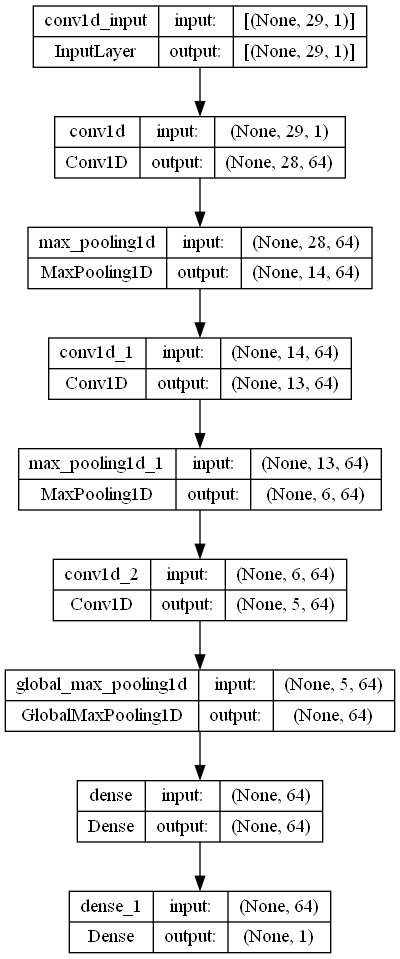

In [49]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Tuning

In [ ]:
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled = np.reshape(X_resampled, (X_resampled.shape[0], -1))

def create_model(hp):
    model = keras.Sequential()
    model.add(layers.Conv1D(hp.Int('conv1_units', min_value=32, max_value=256, step=32), 2, activation='relu', input_shape=(X_resampled.shape[1], 1)))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(hp.Int('conv2_units', min_value=32, max_value=256, step=32), 2, activation='relu'))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.Conv1D(hp.Int('conv3_units', min_value=32, max_value=256, step=32), 2, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(hp.Int('dense_units', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

shutil.rmtree('my_dir', ignore_errors=True)

tuner = Hyperband(
    create_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='my_dir',
    project_name='my_project'
)

tuner.search_space_summary()

tuner.search(X_resampled, y_resampled, epochs=20, validation_data=(X_val, y_val))


best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)

test_loss, test_acc = best_model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)



## RNN

In [ ]:
#Write a RNN model that uses SMOTE
input_shape=len(X_train.columns)
#balance the data with SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled = np.reshape(X_resampled, (X_resampled.shape[0], -1))

# Define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, activation='relu', input_shape=(X_resampled.shape[1], 1)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_resampled, y_resampled, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, early_stop])

y_pred = model.predict(X_val)
y_pred = np.round(y_pred)

print(f'accruacy: {accuracy_score(y_val,y_pred).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred,zero_division=0))


Epoch 1/50
412/412 [==============================] - 5s 8ms/step - loss: 0.6104 - accuracy: 0.6565 - val_loss: 0.4921 - val_accuracy: 0.7583
Epoch 2/50
412/412 [==============================] - 3s 7ms/step - loss: 0.4536 - accuracy: 0.7914 - val_loss: 0.4543 - val_accuracy: 0.7974
Epoch 3/50
412/412 [==============================] - 3s 7ms/step - loss: 0.4150 - accuracy: 0.8147 - val_loss: 0.3827 - val_accuracy: 0.8263
Epoch 4/50
412/412 [==============================] - 3s 7ms/step - loss: 0.3924 - accuracy: 0.8254 - val_loss: 0.4243 - val_accuracy: 0.8101
Epoch 5/50
412/412 [==============================] - 3s 7ms/step - loss: 0.3827 - accuracy: 0.8303 - val_loss: 0.4073 - val_accuracy: 0.8179
Epoch 6/50
412/412 [==============================] - 3s 8ms/step - loss: 0.3715 - accuracy: 0.8346 - val_loss: 0.4131 - val_accuracy: 0.8261
Epoch 7/50
412/412 [==============================] - 3s 7ms/step - loss: 0.3682 - accuracy: 0.8373 - val_loss: 0.3941 - val_accuracy: 0.8177
Epoch 

### Tuning

In [ ]:
def build_model(hp):
    # balance the data with SMOTE
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    X_resampled = np.reshape(X_resampled, (X_resampled.shape[0], -1))

    # Define model architecture
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32),
                                  activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']),
                                  input_shape=(X_resampled.shape[1], 1)),
        tf.keras.layers.Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
                              activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'])),
        tf.keras.layers.Dropout(rate=hp.Float('dense_dropout_rate', min_value=0.0, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

shutil.rmtree('my_dir', ignore_errors=True)
tuner = Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='my_project'
                    )
tuner.search(X_resampled, y_resampled, epochs=20, validation_data=(X_val, y_val))

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.fit(X_resampled, y_resampled, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[tensorboard_callback])

y_pred = model.predict(X_val)
y_pred = np.round(y_pred)

print(f'accruacy: {accuracy_score(y_val,y_pred).round(4)}')


## Random Forests

I will use the random forests ensemble method on the Decision Tree model from the previous section of my analsysis.

A random forest contains many decision trees that all work together to classify new points. The default is 100 classifiers, and each of those trees reports their classification and the random forest returns the most popular classification.

The random forest uses bootstrapping, meaning that each time a decision tree makes a classification it uses a random subset from the dataset. 

In [59]:

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=20, max_depth=2,random_state=0)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_val)

In [60]:
#accuracy score
print(f'accruacy: {accuracy_score(y_val,y_pred).round(4)}')
#get confusion matrix
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
#classification report
print('classification report: ')
print(classification_report(y_val,y_pred,zero_division=0))


accruacy: 0.7369
Confusion Matrix: 
[[3264   31]
 [1252  330]]
classification report: 
              precision    recall  f1-score   support

           0       0.72      0.99      0.84      3295
           1       0.91      0.21      0.34      1582

    accuracy                           0.74      4877
   macro avg       0.82      0.60      0.59      4877
weighted avg       0.78      0.74      0.67      4877



### Bagging

The Random Forests ensemble method is a form of Bootstrap Aggregation or `Bagging`. It uses many classifiers each drawing on random subsets of the data and aggregates the results to find the most common classification.

<p>Bagging is the specific term for the process of boot strapping when applied to random forest classifiers. The idea behind this method is that instead of training all n trees on the entire subset of data we will train each tree on a unique sample of the data.</p>

<p>To start off with we will create bags that are half the size of the training data. So when each bag is made it will contain a unique subset of 1/2 of the entire training set (samples are taken with replacement)</p>

In [61]:
from sklearn.ensemble import BaggingClassifier 
dTree= DecisionTreeClassifier(max_depth=3,class_weight='balanced')               
bg = BaggingClassifier(estimator=dTree, 
                       max_samples = 0.5, 
                       max_features=0.8, 
                       n_estimators=30, 
                       random_state=0)
bg.fit(X_train, y_train)
y_pred = bg.predict(X_val)

#get confusion matrix
bg.score(X_val,y_val)

0.7676850522862415

In [62]:


#get confusion matrix
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
#classification report
print('classification report: ')
print(classification_report(y_val,y_pred,zero_division=0))

Confusion Matrix: 
[[2549  746]
 [ 387 1195]]
classification report: 
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      3295
           1       0.62      0.76      0.68      1582

    accuracy                           0.77      4877
   macro avg       0.74      0.76      0.75      4877
weighted avg       0.79      0.77      0.77      4877



### Hyper Parameter Tuning
<p>We will look at the following parameters</p>
<ul>
<li>max_depth</li>
<li>min_sample_split</li>
<li>max_leaf_nodes</li>
<li>min_samples_leaf</li>
<li>n_estimators</li>
<li>max_sample (bootstrap sample)</li>
<li>max_features</li>
</ul>

In [63]:
#now that we have bagging classifier, lets try to improve the accuracy by using random forest hyperparameter tuning
#create a library with the parameters we want to test
params={'n_estimators': [ 20, 30, 40, 50, 60,80,100,140],
        'max_samples': [ 0.6, 0.7, 0.8, 1.0],                        
        'max_features': [0.2,0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
                     }
#we will pass our bg classifier to the random search
random_search = RandomizedSearchCV(bg, params,n_iter=30, cv=5, verbose=0, random_state=0, n_jobs=-1)
random_search.fit(X_train, y_train)
params = random_search.best_params_

print(params)





KeyboardInterrupt: 

# Final Model

In [49]:
#build a cnn model
input_shape=len(X_train.columns)
#balance the data with SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled = np.reshape(X_resampled, (X_resampled.shape[0], -1))



# Define model architecture
# Define model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(64, 2, activation='relu', input_shape=(X_resampled.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 2, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = callbacks.TensorBoard(log_dir=logdir)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_resampled, y_resampled, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[tensorboard_callback, early_stop])


y_pred = model.predict(X_val)
y_pred = np.round(y_pred)

print(f'accruacy: {accuracy_score(y_val,y_pred).round(4)}')
print('Confusion Matrix: ')
print(confusion_matrix(y_val,y_pred))
print('classification report: ')
print(classification_report(y_val,y_pred,zero_division=0))




Epoch 1/50
412/412 [==============================] - 4s 7ms/step - loss: 0.5179 - accuracy: 0.7401 - val_loss: 0.4206 - val_accuracy: 0.8068
Epoch 2/50
412/412 [==============================] - 3s 7ms/step - loss: 0.4449 - accuracy: 0.7900 - val_loss: 0.4098 - val_accuracy: 0.8148
Epoch 3/50
412/412 [==============================] - 3s 8ms/step - loss: 0.4221 - accuracy: 0.8037 - val_loss: 0.5088 - val_accuracy: 0.7607
Epoch 4/50
412/412 [==============================] - 3s 7ms/step - loss: 0.4041 - accuracy: 0.8116 - val_loss: 0.4050 - val_accuracy: 0.8169
Epoch 5/50
412/412 [==============================] - 3s 7ms/step - loss: 0.3906 - accuracy: 0.8187 - val_loss: 0.3722 - val_accuracy: 0.8347
Epoch 6/50
412/412 [==============================] - 3s 8ms/step - loss: 0.3797 - accuracy: 0.8243 - val_loss: 0.4558 - val_accuracy: 0.7833
Epoch 7/50
412/412 [==============================] - 3s 7ms/step - loss: 0.3692 - accuracy: 0.8319 - val_loss: 0.3886 - val_accuracy: 0.8206
Epoch 

In [50]:
y_pred = model.predict(X_test).round()
df_test['BookingStatus']=y_pred
df_test.to_csv('submission.csv',index=False)

227/227 [==============================] - 0s 1ms/step


In [53]:
df_test.BookingStatus.value_counts()

0.0    4145
1.0    1974
Name: BookingStatus, dtype: int64